###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):** 
Chuen Ley Low: 1078133
Hoan Tran: 1079602


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [28]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import accuracy_score, f1_score
import pickle 
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import random

%matplotlib inline

In [29]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess():
    train_X = []
    train_Y = []
    test_X = []
    test_Y = []
    
    train_file_path = "data/train.csv"
    test_file_path = "data/test.csv"
    
    train_df = pd.read_csv(train_file_path)
    test_df = pd.read_csv(test_file_path)
    
    train_X.append([float(x) for x in list(train_df.columns[1:])])
    train_Y.append(train_df.columns[0])
    
    # Reads through the training data and converts instances into arrays of attributes and classes
    for row in train_df.iterrows():
        temp = []
        for e in row[1][1:]:
            temp.append(e)
            
        train_X.append(temp)
        train_Y.append(row[1][0])
    
    test_X.append([float(x) for x in list(test_df.columns[1:])])
    test_Y.append(test_df.columns[0])
    
    # Reads through the test data and converts instances into arrays of attributes and classes
    for row in test_df.iterrows():
        temp = []
        for e in row[1][1:]:
            temp.append(e)
        
        test_X.append(temp)
        test_Y.append(row[1][0])
    
    return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = preprocess()

In [30]:
# This function should calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(train_X, train_Y):
    label_prob_dict = {}
    groups = {}
    train_dict = {}
    MISSING_POINT = 9999.0
    
    # Converts the arrays of classes and attributes from the training data into a dictionary
    for data, label in zip(train_X, train_Y):
        if label not in groups:
            groups[label] = []
            train_dict[label] = []
        groups[label].append(data)
    
    for key in groups.keys():
        data = groups[key]
        num_attributes = len(data[0])
        num_instance = len(data)
        
        # Calculates and stores the prior probabilities for each class
        label_prob_dict[key] = num_instance / len(train_X)
        
        for i in range(num_attributes):
            total_sum = 0 
            diff_sum = 0
            
            # Calculates the mean for each attribute
            for j in range(num_instance):
                if math.floor(data[j][i]) != MISSING_POINT:
                    total_sum += float(data[j][i]) 
            
            mean = total_sum / num_instance
            
            # Calculates the standard deviation for each attribute
            for j in range(num_instance):
                if math.floor(data[j][i]) != MISSING_POINT:
                    diff_sum += ((float(data[j][i]) - mean) ** 2)
                
            std_dev = math.sqrt(diff_sum / num_instance)
            
            train_dict[key].append((mean, std_dev))
            
    return train_dict, label_prob_dict, groups

train_dict, label_prob_dict, group_data = train(train_X, train_Y)

In [31]:
# This function takes in an x value, mean, and standard deviation uses the pdf of the gaussian  
# distribution to return the probability of the x value

def GaussianFunction(x, mean, std_dev):
    x = float(x)
    base = 1 / (std_dev * math.sqrt(2 * math.pi))
    exponent = math.exp(-0.5 * ((x - mean)/std_dev) ** 2)
    return base * exponent

In [32]:
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set)

def predict(test_X, train_dict, label_prob_dict):
    predictions = []
    MISSING_POINT = 9999.0
    
    for i in range(len(test_X)):
        instance = test_X[i]
        prob_arr = []
        
        # Calculate the Gaussian probability for each label
        for label in train_dict.keys():        
            prob = math.log(label_prob_dict[label], 2)
            
            for j in range(len(instance)):
                if math.floor(instance[j]) != MISSING_POINT:
                    mean, std_dev = train_dict[label][j]
                    gaussian_prob = GaussianFunction(instance[j], mean, std_dev)
                    
                    if gaussian_prob != 0.0:
                        prob += math.log(GaussianFunction(instance[j], mean, std_dev), 2)
            prob_arr.append(prob)
        
        max_arg = np.argmax(prob_arr)
        predicted_label = list(train_dict.keys())[max_arg]
        predictions.append(predicted_label)
    
    # Writes the predictions into a csv file
    pd.DataFrame(predictions).to_csv("predictions.csv", index = False, header = False)
    
    return predictions

predictions = predict(test_X, train_dict, label_prob_dict)

In [33]:
# This function should evaluate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(test_Y, predictions):
    total_correct = 0
    
    # Compares all the predicted labels with the truth labels to calculate accuracy
    for i in range(len(test_Y)):
        if predictions[i] == test_Y[i]:
            total_correct += 1
    
    accuracy = total_correct / len(test_Y)
    
    return accuracy
    
evaluate(test_Y, predictions)

0.7413793103448276

## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 150–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [34]:
true_positives = {}
true_negatives = {}
false_positives = {}
false_negatives = {}
class_proportions = {}
    
for key in train_dict.keys():
    true_positives[key] = 0
    true_negatives[key] = 0
    false_positives[key] = 0
    false_negatives[key] = 0
    class_proportions[key] = 0


for i in range(len(test_Y)):
        
    # When predictions match actual
    if predictions[i] == test_Y[i]:
        true_positives[predictions[i]] += 1
        for key in train_dict.keys():
            if key != predictions[i]:
                true_negatives[key] += 1
                    
    # When prediction does not match
    else:
        false_positives[predictions[i]] += 1
        false_negatives[test_Y[i]] += 1
        for key in train_dict.keys():
            if key != predictions[i] and key != test_Y[i]:
                true_negatives[key] += 1
    
    
# Micro Averaging 
    
# Recall And Precision
total_true_positives = 0
total_false_neg = 0
total_false_pos = 0
for key in true_positives:
    total_true_positives += true_positives[key]
    total_false_neg += false_negatives[key]
    total_false_pos += false_positives[key]
    
recall = total_true_positives / (total_true_positives + total_false_neg)
precision = total_true_positives / (total_true_positives + total_false_pos)
f1_score = 2 * ((precision * recall) / (precision + recall))

print(f"Micro Average Recall: {recall:.4f}")
print(f"Micro Average Precision: {precision:.4f}")
print(f"Micro Average F1 Score: {f1_score:.4f}")
    
    
# Macro Averaging
    
# Get the recall and precision for each class
class_recall = {}
class_precision = {}
recall = 0
precision = 0

for key in true_positives.keys():
    class_recall[key] = true_positives[key] / (true_positives[key] + false_negatives[key])
    class_precision[key] = true_positives[key] / (true_positives[key] + false_positives[key])
    
    recall += class_recall[key]
    precision += class_precision[key]
    
recall /= len(class_recall)
precision /= len(class_precision)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("\n")
print(f"Macro Average Recall: {recall:.4f}")
print(f"Macro Average Precision: {precision:.4f}")
print(f"Macro Average F1 Score: {f1_score:.4f}")
    
    
# Weight Averaging
    
# Get class proportions
for instance in test_Y:
    if instance in class_proportions:
        class_proportions[instance] += 1
    else:
        class_proportions[instance] = 1
    
recall = 0
precision = 0
for key in class_proportions:
    class_proportions[key] /= len(test_Y)
        
    recall += (class_proportions[key]) * (class_recall[key])
    precision += (class_proportions[key]) * (class_precision[key])

f1_score = 2 * ((precision * recall) / (precision + recall))

print("\n")
print(f"Weighted Average Recall: {recall:.4f}")
print(f"Weighted Average Precision: {precision:.4f}")
print(f"Weighted Average F1 Score: {f1_score:.4f}")   

print("\n")
print("Class Proportions")
for label in class_proportions:
    print(f"{label}: {class_proportions[label]:.4f}")

Micro Average Recall: 0.7414
Micro Average Precision: 0.7414
Micro Average F1 Score: 0.7414


Macro Average Recall: 0.7416
Macro Average Precision: 0.7137
Macro Average F1 Score: 0.7274


Weighted Average Recall: 0.7414
Weighted Average Precision: 0.7571
Weighted Average F1 Score: 0.7491


Class Proportions
bridge: 0.1207
childs: 0.1121
downwarddog: 0.1552
mountain: 0.2586
plank: 0.0776
seatedforwardbend: 0.0776
tree: 0.0517
trianglepose: 0.0345
warrior1: 0.0431
warrior2: 0.0690


### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

In [35]:
# Plot the the left wrist points for the classes {mountain, tree and trianglepose}
# For Left Wrist coordinates, we extract the x and y coordinates

def pose_point_summary(pose, point):
    MISSING_POINT = 9999.0
    MAX_POINTS = 11
    LEFT_WRIST_X = 6
    LEFT_WRIST_Y = 17
    
    points = group_data[pose]

    # Plot all the instances for the point
    x_vals = []
    y_vals = []

    for row in points:
        if row[point] != MISSING_POINT and row[point + MAX_POINTS] != MISSING_POINT:
            x_vals.append(row[point])
            y_vals.append(row[point + MAX_POINTS])

    for i in range(len(x_vals)):
        plt.plot(x_vals[i], y_vals[i], 'o', markersize = 5)
        plt.title(f'Coordinates for {pose}')
        plt.xlabel("X Coordinates")
        plt.ylabel("Y Coordinates")

    plt.show()
    plt.clf()


    # X Coordinate

    # Plot a histogram graph and Gaussian distribution for x-coord
    plt.hist(x_vals, density = True)
    mean_x =  train_dict[pose][point][0]
    std_dev_x = train_dict[pose][point + MAX_POINTS][1]

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax,  100)
    p = stats.norm.pdf(x, mean_x, std_dev_x)
    plt.plot(x, p, 'k', linewidth = 2)
    plt.title(f'{pose}: X-coord histogram and Gaussian dist.')
    plt.show()
    plt.clf()

    # Plot the QQ plot for the x coordinate
    sm.qqplot(np.array(x_vals), fit = True, line = '45')
    plt.title(f"{pose}: X-coord QQ-plot")
    plt.show()
    plt.clf()


    # Y Coordinate

    # Plot a histogram graph and Gaussian distribution for y-coord
    plt.hist(y_vals, density = True)
    mean_y =  train_dict[pose][point + MAX_POINTS][0]
    std_dev_y = train_dict[pose][point + MAX_POINTS][1]

    ymin, ymax = plt.xlim()
    y = np.linspace(ymin, ymax,  100)
    p = stats.norm.pdf(y, mean_y, std_dev_y)
    plt.plot(y, p, 'k', linewidth = 2)
    plt.title(f'{pose}: Y-coord histogram and Gaussian dist.')
    plt.show()
    plt.clf()

    # Plot the QQ plot for the x coordinate
    sm.qqplot(np.array(y_vals), fit = True, line = '45')
    plt.title(f"{pose}: Y-coord QQ-plot")
    plt.show()
    plt.clf()

In [36]:
for key in class_precision:
    print(f"{key}: {class_precision[key]:.4f}")

bridge: 0.5714
childs: 0.7143
downwarddog: 0.8125
mountain: 0.8667
plank: 0.8333
seatedforwardbend: 0.7143
tree: 0.4286
trianglepose: 0.5714
warrior1: 0.6250
warrior2: 1.0000


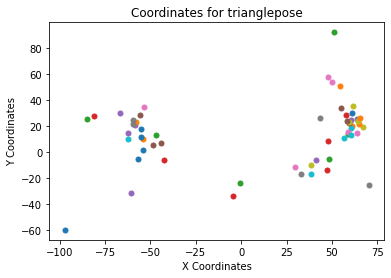

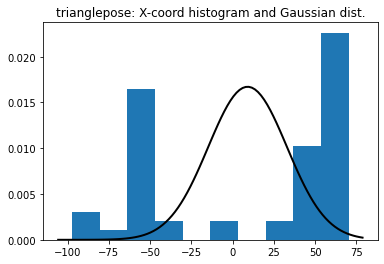

<Figure size 432x288 with 0 Axes>

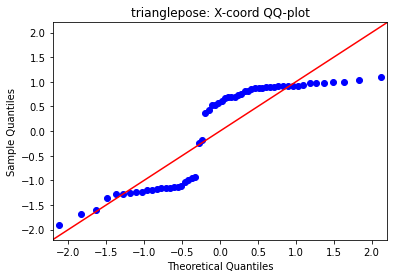

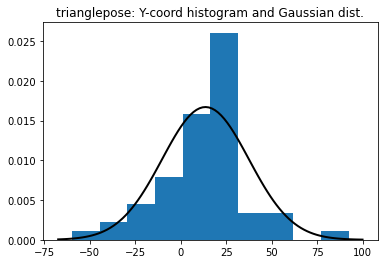

<Figure size 432x288 with 0 Axes>

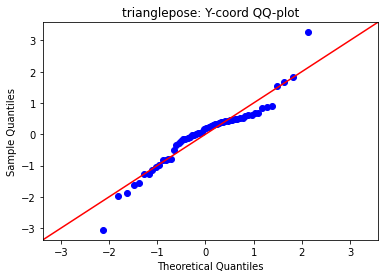

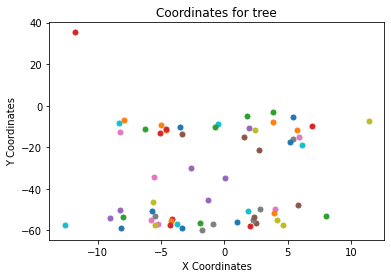

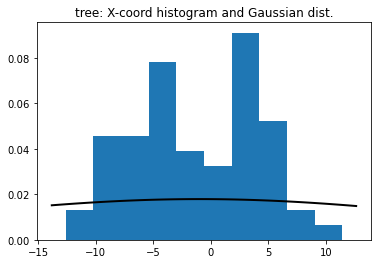

<Figure size 432x288 with 0 Axes>

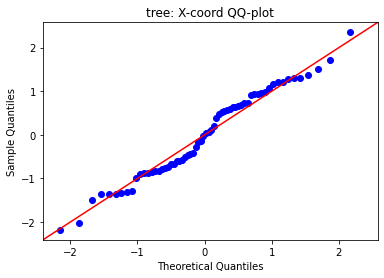

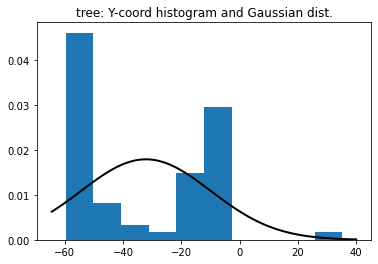

<Figure size 432x288 with 0 Axes>

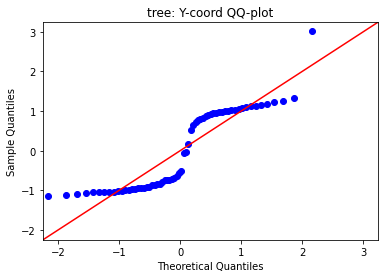

<Figure size 432x288 with 0 Axes>

In [37]:
pose_point_summary('trianglepose', 6)
pose_point_summary('tree', 6)

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [44]:
# KDE Implementation for calculating our probabilities
#def calculate_KDE_probability(value):
    
def predict_with_KDE(test_X, label_prob_dict, kernal_size): 
    MISSING_POINT = 9999.0
    
    predictions = []
    
    for instance in test_X:
        prob_arr = []
        
        for label in train_dict:
            gaussian_KDE_prob = math.log(label_prob_dict[label], 2)
            
            for i in range(len(instance)):
                value = instance[i]
                if math.floor(value) == MISSING_POINT:
                    continue
                    
                total_prob = 0
                count = 0
                train_rows = group_data[label]
                
                for train_instance in train_rows:
                    if math.floor(train_instance[i]) != MISSING_POINT:
                        total_prob += GaussianFunction(value, train_instance[i], std_dev = kernal_size)
                        count += 1
                        
                avg_prob = total_prob / count
                if (avg_prob > 0):
                    gaussian_KDE_prob += math.log(avg_prob, 2)
            
            prob_arr.append(gaussian_KDE_prob)
            
        max_arg = np.argmax(prob_arr)
        predicted_label = list(train_dict.keys())[max_arg]
        predictions.append(predicted_label)
    
    pd.DataFrame(predictions).to_csv("KDE_predictions.csv", index = False, header = False)
    return predictions
                
KDE_predictions = predict_with_KDE(test_X, label_prob_dict, 10)  
print(evaluate(test_Y, predictions))
accuracy_score(test_Y, KDE_predictions)

0.7413793103448276


0.7758620689655172

In [39]:
# Calculating class accuracy for KDE predictions
# Get the recall and precision for each class

true_positives = {}
true_negatives = {}
false_positives = {}
false_negatives = {}
class_proportions = {}
    
for key in train_dict.keys():
    true_positives[key] = 0
    true_negatives[key] = 0
    false_positives[key] = 0
    false_negatives[key] = 0
    class_proportions[key] = 0

for i in range(len(test_Y)):
        
    # When predictions match actual
    if KDE_predictions[i] == test_Y[i]:
        true_positives[predictions[i]] += 1
        for key in train_dict.keys():
            if key != predictions[i]:
                true_negatives[key] += 1
                    
    # When prediction does not match
    else:
        false_positives[predictions[i]] += 1
        false_negatives[test_Y[i]] += 1
        for key in train_dict.keys():
            if key != predictions[i] and key != test_Y[i]:
                true_negatives[key] += 1

class_recall = {}
class_KDE_precision = {}

for key in true_positives.keys():
    class_recall[key] = true_positives[key] / (true_positives[key] + false_negatives[key])
    class_KDE_precision[key] = true_positives[key] / (true_positives[key] + false_positives[key])
    

for key in class_precision:
    print(f"{key}: Gaussian = {class_precision[key]:.4f}, KDE = {class_KDE_precision[key]:.4f}")

bridge: Gaussian = 0.5714, KDE = 0.7143
childs: Gaussian = 0.7143, KDE = 0.6429
downwarddog: Gaussian = 0.8125, KDE = 0.8750
mountain: Gaussian = 0.8667, KDE = 0.8667
plank: Gaussian = 0.8333, KDE = 0.8333
seatedforwardbend: Gaussian = 0.7143, KDE = 0.7143
tree: Gaussian = 0.4286, KDE = 0.4286
trianglepose: Gaussian = 0.5714, KDE = 1.0000
warrior1: Gaussian = 0.6250, KDE = 0.5000
warrior2: Gaussian = 1.0000, KDE = 1.0000


### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

In [40]:
def get_random():
    return 0.2

def split_dataset(training, testing, n = 5):
    paired = list(zip(training, testing))
    random.shuffle(paired, get_random)
    split = np.array_split(paired, n)
    train_split = []
    label_split = []
    
    for item in split:
        training = []
        labels = []
        
        for instance in item:
            training.append(instance[0])
            labels.append(instance[1])

        train_split.append(training)
        label_split.append(labels)
    
    return train_split, label_split

train_split, label_split = split_dataset(train_X, train_Y, 5)

def perform_cross_validation(data_split, label_split):
    
    score = 0
    for i in range(len(data_split)):
        train_rows = []
        train_label_rows = []
        test_rows = data_split[i]
        test_label_rows = label_split[i]
        
        for j in range(len(data_split)):
            if j != i:
                for k in range(len(data_split[j])):
                    train_rows.append(data_split[j][k])
                for label in label_split[j]:
                    train_label_rows.append(label)
        
        print(len(train_rows), len(test_rows))
        train_dict, label_prob_dict, _ = train(train_rows, train_label_rows)
        KDE_predictions = predict_with_KDE(test_rows, label_prob_dict, 10)
        score += evaluate(test_label_rows, KDE_predictions)
    
    print(f"Accuracy Score: {score / len(data_split)}")

perform_cross_validation(train_split, label_split)

597 150


C:\Users\nonam\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


597 150
598 149
598 149
598 149
Accuracy Score: 0.8836868008948546


### Q5
Naive Bayes ignores missing values, but in pose recognition tasks the missing values can be informative. Missing values indicate that some part of the body was obscured and sometimes this is relevant to the pose (e.g., holding one hand behind the back). Are missing values useful for this task? Implement a method that incorporates information about missing values and demonstrate whether it changes the classification results.

### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.